In [87]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime
import sys
sys.path.append(R'C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Scoring Worlflow')

# Read Data File

In [88]:
df= pd.read_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\backup2.csv")


In [89]:
df1 = pd.read_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\backup3.csv")

In [90]:
df = df.merge(df1, on= 'SKP_CREDIT_CASE', how = 'inner')

# Create features for Analysis 

In [91]:
features_list = ['POS_ORDER',
       'POS_500m', 'POS_1km', 'POS_2km', 'POS_3km', 'POS_5km', 'CUST_500m', 'CUST_1km',
       'CUST_2km', 'CUST_3km', 'CUST_5km',
       'DISTANCE_FROM_POS','DISTANCE_FROM_NEAREST_POS','RATIO_DISTANCE_CUS_POS_NEAREST_POS']

In [92]:
df["RATIO_DISTANCE_CUS_POS_NEAREST_POS"] = df['DISTANCE_FROM_POS']/df['DISTANCE_FROM_NEAREST_POS']

In [93]:
df.head()

,Unnamed: 0_x,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,...,NEAREST_POS_LAT,NEAREST_POS_LONG,DISTANCE_FROM_NEAREST_POS,Unnamed: 0_y,CUST_500m,CUST_1km,CUST_2km,CUST_3km,CUST_5km,RATIO_DISTANCE_CUS_POS_NEAREST_POS
0,0,245663258,2019-08-04,30.817513,75.188828,0.0,0.0,0.0,0.0,0.0,...,30.816818,75.185576,0.319998,0,11,20,59,75,88,4.918633
1,1,243527210,2019-07-12,30.817513,75.188828,0.0,0.0,0.0,0.0,0.0,...,30.816818,75.185576,0.319998,1,11,20,59,75,88,4.918633
2,2,245406342,2019-07-27,30.817073,75.183539,0.0,0.0,0.0,0.0,0.0,...,30.816818,75.185576,0.196571,2,11,21,66,75,87,5.454364
3,3,227674475,2019-03-06,30.817073,75.183539,0.0,0.0,0.0,0.0,0.0,...,30.816818,75.185576,0.196571,3,11,21,66,75,87,5.414108
4,4,230730436,2019-03-31,30.818386,75.186915,0.0,0.0,0.0,0.0,0.0,...,30.816818,75.185576,0.216159,4,10,23,62,76,88,6.196613


In [94]:
df.TIME_DECISION_DATE = pd.to_datetime(df.TIME_DECISION_DATE,format = '%Y-%m-%d')

In [95]:
df["MONTH_STR"] = df.TIME_DECISION_DATE.dt.strftime(date_format = "%Y-%m")

In [96]:
df.head()

,Unnamed: 0_x,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,...,NEAREST_POS_LONG,DISTANCE_FROM_NEAREST_POS,Unnamed: 0_y,CUST_500m,CUST_1km,CUST_2km,CUST_3km,CUST_5km,RATIO_DISTANCE_CUS_POS_NEAREST_POS,MONTH_STR
0,0,245663258,2019-08-04,30.817513,75.188828,0.0,0.0,0.0,0.0,0.0,...,75.185576,0.319998,0,11,20,59,75,88,4.918633,2019-08
1,1,243527210,2019-07-12,30.817513,75.188828,0.0,0.0,0.0,0.0,0.0,...,75.185576,0.319998,1,11,20,59,75,88,4.918633,2019-07
2,2,245406342,2019-07-27,30.817073,75.183539,0.0,0.0,0.0,0.0,0.0,...,75.185576,0.196571,2,11,21,66,75,87,5.454364,2019-07
3,3,227674475,2019-03-06,30.817073,75.183539,0.0,0.0,0.0,0.0,0.0,...,75.185576,0.196571,3,11,21,66,75,87,5.414108,2019-03
4,4,230730436,2019-03-31,30.818386,75.186915,0.0,0.0,0.0,0.0,0.0,...,75.185576,0.216159,4,10,23,62,76,88,6.196613,2019-03


In [97]:
df = df[~df["RATIO_DISTANCE_CUS_POS_NEAREST_POS"].isin([0,np.inf,np.nan])]

In [98]:
df.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\POS_features.pkl")

# WOE Analysis

In [99]:
#df=df1
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 3, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 4, 30))]
df_valid = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 5, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 5, 31))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 6, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 8, 31))]

In [100]:
cols_pred_num=features_list
cols_pred_cat = []

In [109]:
from scoring.grouping import Grouping

grouping = Grouping(columns = sorted(cols_pred_num),
                    cat_columns = sorted(cols_pred_cat),
                    group_count=4, 
                    min_samples=4000)

grouping.fit(df_train[cols_pred_num],
             df_train["RISK_FSTQPD30"],
          #   w=data[train_mask][col_weight],
            progress_bar=True, category_limit=10000);

grouping.save(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\my_grouping")

data_woe = grouping.transform(df, transform_to='woe', progress_bar=True)

'Grouping saved on 2020-04-01 00:21:22 to file C:\\Users\\aman.khatri91425\\Desktop\\HomeCredit\\Bigdata\\Common Maps KNN\\my_grouping'

### Plot Bins

***

### CUST_1km

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_CUST_1km,,,,,,,,
"[-inf, 0.5)",49137.0,3990.0,0.0812,0.0953,0.0775,-0.2038,-0.2064,0.0787
"[0.5, 4.5)",95332.0,7076.0,0.0742,0.1690,0.1516,-0.1075,-0.1090,0.1527
"[4.5, 19.5)",196279.0,13156.0,0.0670,0.3142,0.3145,0.0008,0.0008,0.3145
"[19.5, inf)",283439.0,17646.0,0.0623,0.4215,0.4564,0.0786,0.0797,0.4541
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.6325,0.0000


IV: 0.0084
Gini: 4.74


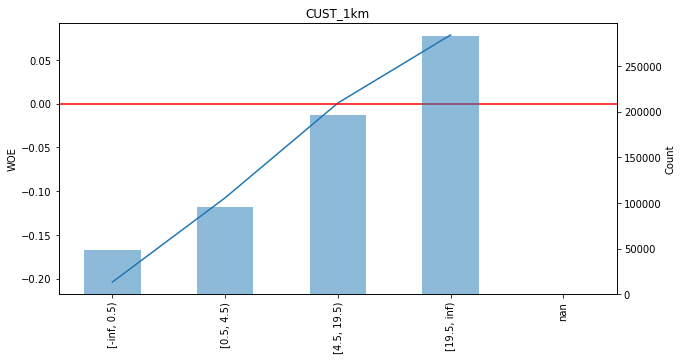

***

### CUST_2km

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_CUST_2km,,,,,,,,
"[-inf, 1.5)",47038.0,3949.0,0.0840,0.0943,0.0740,-0.2397,-0.2427,0.0754
"[1.5, 9.5)",72682.0,5497.0,0.0756,0.1313,0.1154,-0.1276,-0.1292,0.1164
"[9.5, 37.5)",134907.0,9184.0,0.0681,0.2194,0.2159,-0.0157,-0.0159,0.2161
"[37.5, inf)",369560.0,23238.0,0.0629,0.5550,0.5947,0.0681,0.0691,0.5921
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.6325,0.0000


IV: 0.0098
Gini: 4.80


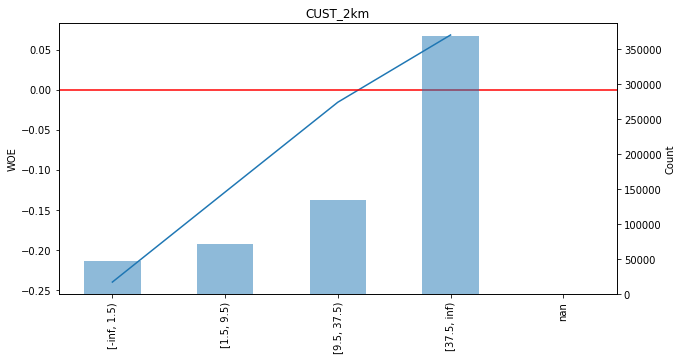

***

### CUST_3km

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_CUST_3km,,,,,,,,
"[-inf, 3.5)",49203.0,4178.0,0.0849,0.0998,0.0773,-0.2520,-0.2551,0.0788
"[3.5, 17.5)",66227.0,5045.0,0.0762,0.1205,0.1051,-0.1353,-0.1370,0.1061
"[17.5, 68.5)",131508.0,8964.0,0.0682,0.2141,0.2104,-0.0170,-0.0172,0.2107
"[68.5, inf)",377249.0,23681.0,0.0628,0.5656,0.6072,0.0699,0.0709,0.6044
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.6325,0.0000


IV: 0.0109
Gini: 5.00


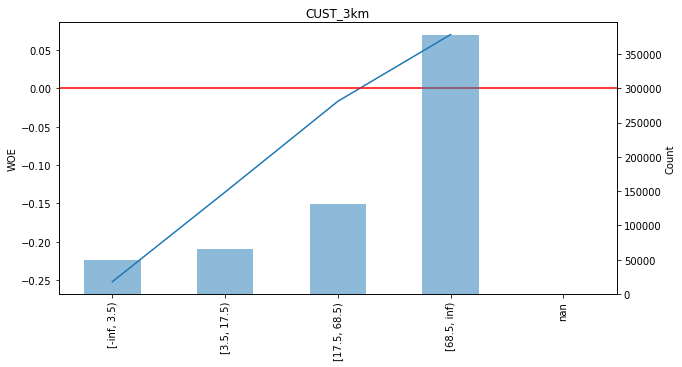

***

### CUST_500m

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_CUST_500m,,,,,,,,
"[-inf, 0.5)",84935.0,6533.0,0.0769,0.1560,0.1346,-0.1456,-0.1475,0.1361
"[0.5, 3.5)",151930.0,10733.0,0.0706,0.2564,0.2425,-0.0549,-0.0557,0.2434
"[3.5, 9.5)",171256.0,11120.0,0.0649,0.2656,0.2750,0.0343,0.0348,0.2744
"[9.5, inf)",216066.0,13482.0,0.0624,0.3220,0.3479,0.0762,0.0773,0.3462
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.6325,0.0000


IV: 0.0063
Gini: 4.24


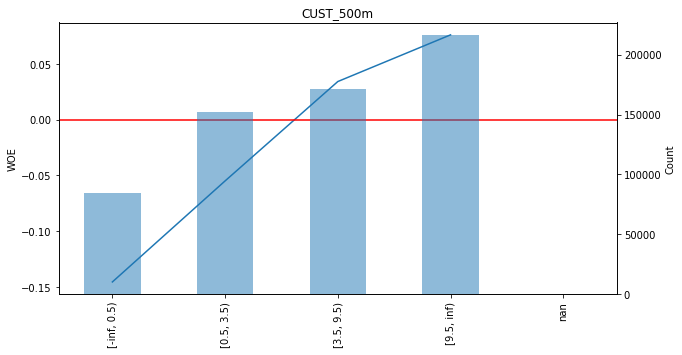

***

### CUST_5km

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_CUST_5km,,,,,,,,
"[-inf, 3.5)",26452.0,2366.0,0.0894,0.0565,0.0414,-0.3084,-0.3121,0.0424
"[3.5, 26.5)",65899.0,5261.0,0.0798,0.1257,0.1041,-0.1855,-0.1879,0.1056
"[26.5, 136.5)",147453.0,10173.0,0.0690,0.2430,0.2357,-0.0298,-0.0302,0.2362
"[136.5, inf)",384383.0,24068.0,0.0626,0.5749,0.6188,0.0725,0.0736,0.6158
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.6325,0.0000


IV: 0.0122
Gini: 5.22


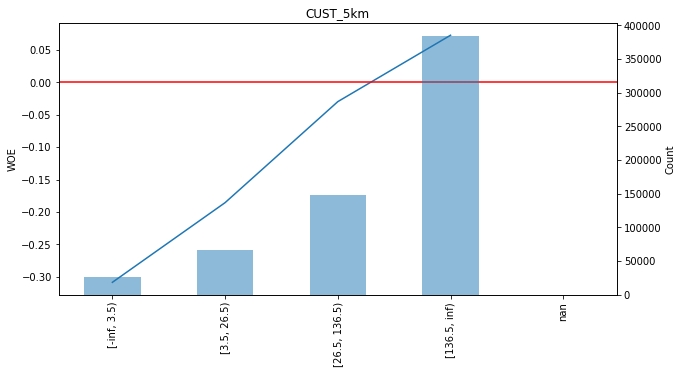

***

### DISTANCE_FROM_NEAREST_POS

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DISTANCE_FROM_NEAREST_POS,,,,,,,,
"[-inf, 0.3222)",287320.0,18358.0,0.0639,0.4385,0.4619,0.0513,0.0520,0.4603
"[0.3222, 3.7126)",278391.0,18734.0,0.0673,0.4475,0.4459,-0.0034,-0.0035,0.4460
"[3.7126, 7.1406)",27314.0,2098.0,0.0768,0.0501,0.0433,-0.1441,-0.1460,0.0438
"[7.1406, inf)",31162.0,2678.0,0.0859,0.0640,0.0489,-0.2650,-0.2682,0.0499
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.6325,0.0000


IV: 0.0063
Gini: 3.33


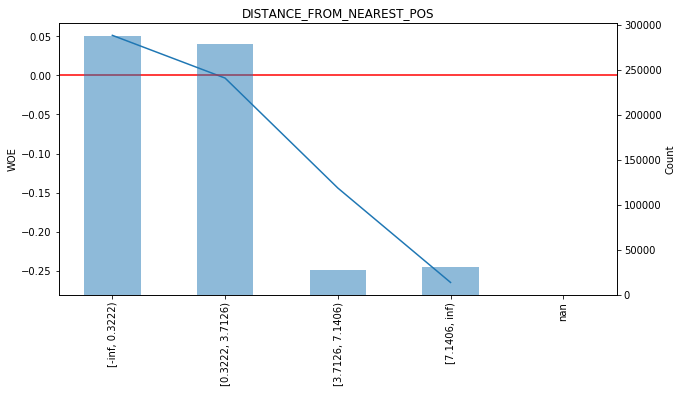

***

### DISTANCE_FROM_POS

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DISTANCE_FROM_POS,,,,,,,,
"[-inf, 0.6859)",127004.0,7563.0,0.0595,0.1806,0.2051,0.1252,0.1271,0.2035
"[0.6859, 3.7115)",301581.0,19954.0,0.0662,0.4766,0.4836,0.0145,0.0147,0.4832
"[3.7115, 16.9123)",161757.0,11601.0,0.0717,0.2771,0.2579,-0.0710,-0.0719,0.2591
"[16.9123, inf)",33845.0,2750.0,0.0813,0.0657,0.0534,-0.2045,-0.2071,0.0542
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.6325,0.0000


IV: 0.0071
Gini: 4.40


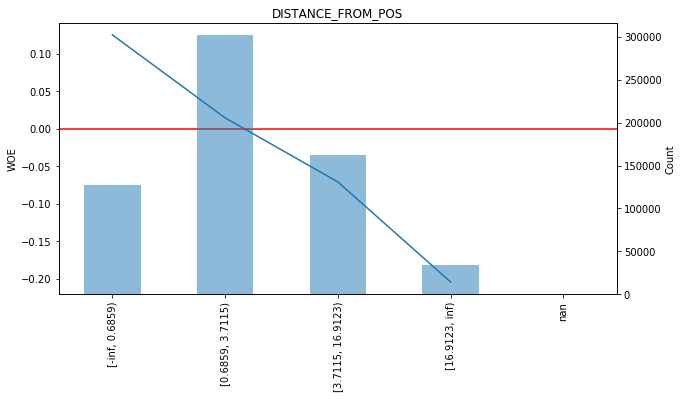

***

### POS_1km

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_POS_1km,,,,,,,,
"[-inf, 0.5)",136016.0,10066.0,0.0740,0.2404,0.2163,-0.1044,-0.1058,0.2179
"[0.5, 6.5)",121986.0,8389.0,0.0688,0.2004,0.1951,-0.0264,-0.0268,0.1954
"[6.5, 62.5)",353822.0,22529.0,0.0637,0.5381,0.5689,0.0549,0.0557,0.5669
"[62.5, inf)",12363.0,884.0,0.0715,0.0211,0.0197,-0.0678,-0.0687,0.0198
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.6325,0.0000


IV: 0.0045
Gini: 3.47


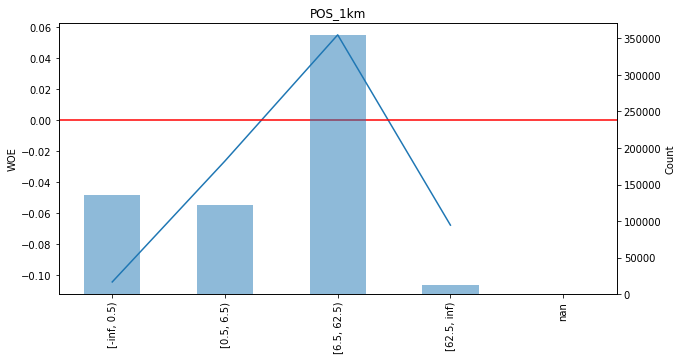

***

### POS_2km

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_POS_2km,,,,,,,,
"[-inf, 0.5)",85230.0,6657.0,0.0781,0.1590,0.1349,-0.1620,-0.1641,0.1365
"[0.5, 1.5)",13575.0,978.0,0.0720,0.0234,0.0216,-0.0758,-0.0768,0.0217
"[1.5, 172.5)",518995.0,33763.0,0.0651,0.8064,0.8333,0.0323,0.0328,0.8315
"[172.5, inf)",6387.0,470.0,0.0736,0.0112,0.0102,-0.0983,-0.0996,0.0102
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.6325,0.0000


IV: 0.0051
Gini: 2.73


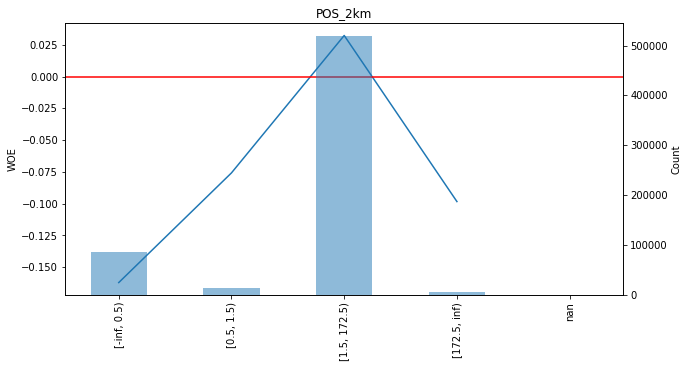

***

### POS_3km

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_POS_3km,,,,,,,,
"[-inf, 0.5)",65270.0,5233.0,0.0802,0.1250,0.1031,-0.1901,-0.1925,0.1046
"[0.5, 5.5)",30922.0,2272.0,0.0735,0.0543,0.0492,-0.0967,-0.0980,0.0495
"[5.5, 289.5)",517444.0,33565.0,0.0649,0.8017,0.8310,0.0354,0.0359,0.8290
"[289.5, inf)",10551.0,798.0,0.0756,0.0191,0.0167,-0.1276,-0.1293,0.0169
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.6325,0.0000


IV: 0.0061
Gini: 3.00


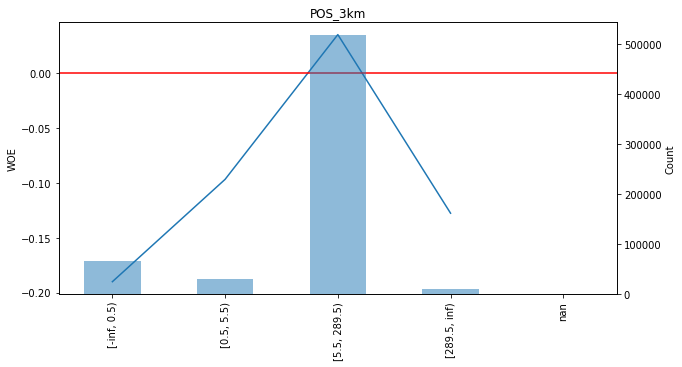

***

### POS_500m

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_POS_500m,,,,,,,,
"[-inf, 1.5)",296469.0,20907.0,0.0705,0.4994,0.4732,-0.0530,-0.0538,0.4750
"[1.5, 7.5)",186225.0,12193.0,0.0655,0.2912,0.2989,0.0255,0.0259,0.2983
"[7.5, 20.5)",117495.0,7189.0,0.0612,0.1717,0.1894,0.0968,0.0982,0.1882
"[20.5, inf)",23998.0,1579.0,0.0658,0.0377,0.0385,0.0203,0.0206,0.0384
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.6325,0.0000


IV: 0.0034
Gini: 3.06


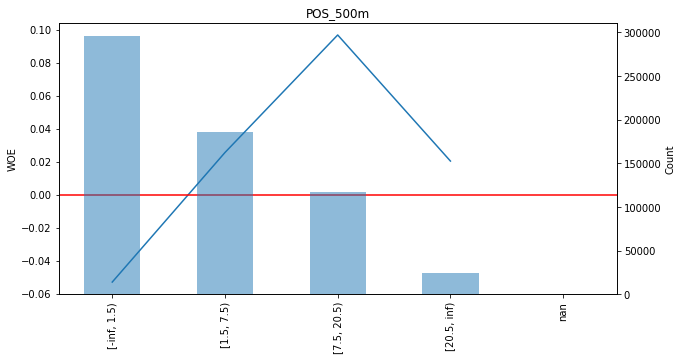

***

### POS_5km

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_POS_5km,,,,,,,,
"[-inf, 5.5)",64032.0,5223.0,0.0816,0.1247,0.1010,-0.2086,-0.2113,0.1026
"[5.5, 82.5)",152060.0,10390.0,0.0683,0.2482,0.2433,-0.0196,-0.0198,0.2436
"[82.5, 652.5)",402192.0,25789.0,0.0641,0.6160,0.6464,0.0475,0.0482,0.6443
"[652.5, inf)",5903.0,466.0,0.0789,0.0111,0.0093,-0.1735,-0.1757,0.0095
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.6325,0.0000


IV: 0.0069
Gini: 3.61


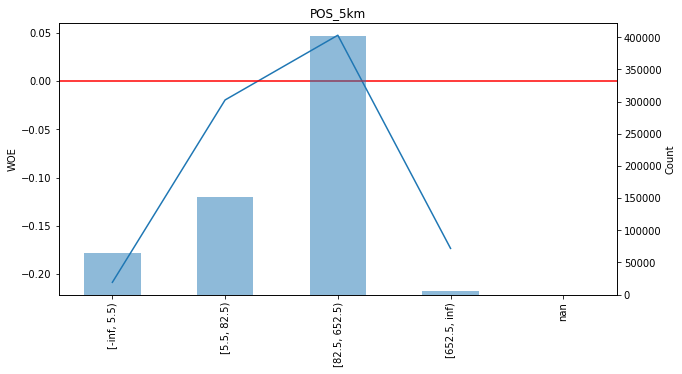

***

### POS_ORDER

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_POS_ORDER,,,,,,,,
"[-inf, 5.5)",114194.0,7167.0,0.0628,0.1712,0.1838,0.0701,0.0711,0.1829
"[5.5, 39.5)",267438.0,17829.0,0.0667,0.4258,0.4286,0.0065,0.0066,0.4285
"[39.5, 41.5)",7124.0,541.0,0.0759,0.0129,0.0113,-0.1319,-0.1337,0.0114
"[41.5, inf)",235431.0,16331.0,0.0694,0.3901,0.3763,-0.0355,-0.0360,0.3772
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.6325,0.0000


IV: 0.0016
Gini: 2.08


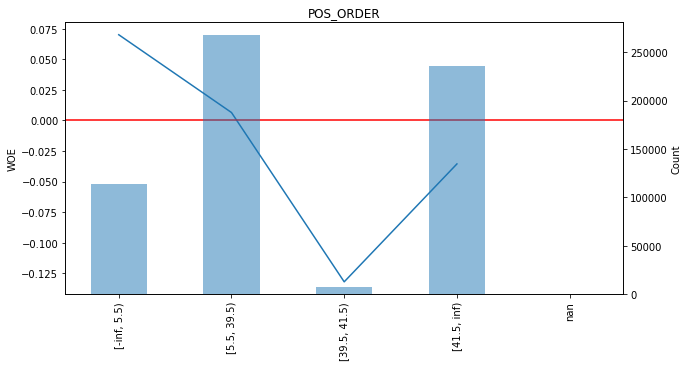

***

### RATIO_DISTANCE_CUS_POS_NEAREST_POS

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_RATIO_DISTANCE_CUS_POS_NEAREST_POS,,,,,,,,
"[-inf, 1.0014)",28895.0,1834.0,0.0635,0.0438,0.0465,0.0583,0.0591,0.0463
"[1.0014, 1.0753)",23144.0,1736.0,0.0750,0.0415,0.0368,-0.1188,-0.1203,0.0371
"[1.0753, 13.6211)",443343.0,29470.0,0.0665,0.7039,0.7107,0.0096,0.0097,0.7103
"[13.6211, inf)",128747.0,8824.0,0.0685,0.2108,0.2059,-0.0228,-0.0231,0.2063
nan,58.0,4.0,0.0690,0.0001,0.0001,-0.0294,-0.0300,0.0001


IV: 0.0009
Gini: 1.19


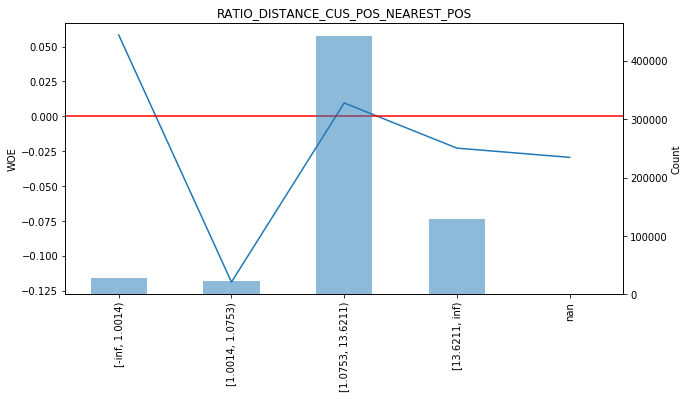

In [110]:
grouping.plot_bins(data=df_train, cols_pred_num=cols_pred_num, cols_pred_cat=cols_pred_cat,
                    mask = pd.Series(df_train["SKP_CREDIT_CASE"]>=0),col_target="RISK_FSTQPD30", 
                   output_folder=r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN", col_weight=None)

In [111]:
woe_columns_to_replace = list()
for column in data_woe.columns:
    if column in df:
        woe_columns_to_replace.append(column)
        print('Column', column ,'dropped as it already existed in the data set.')
df = df.drop(woe_columns_to_replace, axis='columns')
df = df.join(-data_woe)

print('Added WOE variables. Number of columns:',df.shape[1])
cols_woe = [s + '_WOE' for s in cols_pred_num]

Column CUST_1km_WOE dropped as it already existed in the data set.
Column CUST_2km_WOE dropped as it already existed in the data set.
Column CUST_3km_WOE dropped as it already existed in the data set.
Column CUST_500m_WOE dropped as it already existed in the data set.
Column CUST_5km_WOE dropped as it already existed in the data set.
Column DISTANCE_FROM_NEAREST_POS_WOE dropped as it already existed in the data set.
Column DISTANCE_FROM_POS_WOE dropped as it already existed in the data set.
Column POS_1km_WOE dropped as it already existed in the data set.
Column POS_2km_WOE dropped as it already existed in the data set.
Column POS_3km_WOE dropped as it already existed in the data set.
Column POS_500m_WOE dropped as it already existed in the data set.
Column POS_5km_WOE dropped as it already existed in the data set.
Column POS_ORDER_WOE dropped as it already existed in the data set.
Column RATIO_DISTANCE_CUS_POS_NEAREST_POS_WOE dropped as it already existed in the data set.
Added WOE va

In [63]:
cols_woe

['POS_ORDER_WOE',
 'POS_500m_WOE',
 'POS_1km_WOE',
 'POS_2km_WOE',
 'POS_3km_WOE',
 'POS_5km_WOE',
 'CUST_500m_WOE',
 'CUST_1km_WOE',
 'CUST_2km_WOE',
 'CUST_3km_WOE',
 'CUST_5km_WOE',
 'DISTANCE_FROM_POS_WOE',
 'DISTANCE_FROM_NEAREST_POS_WOE',
 'RATIO_DISTANCE_CUS_POS_NEAREST_POS_WOE']

# Gini and IV of Features for Comparison

In [79]:
df1=df

### Reduce sample size to reduce computation in calculations for IV, Gini

In [ ]:
df = df1.sample(n=300000,random_state=2)

In [81]:
for x in features_list:
    df[x+"_BINS"] = pd.qcut(df[x],10,duplicates = 'drop')

In [82]:
from scoring.metrics import iv,gini
cols_list= features_list
col_target= 'RISK_FSTQPD30'
power_tab = {'VARIABLE_NAME':[],'IV':[],'GINI':[], 'GINI_WOE':[]}
for j in range(0,len(cols_list)):
        power_tab["VARIABLE_NAME"].append(cols_list[j])
        power_tab["IV"].append("{:.2%}".format(iv(df[col_target],df[cols_list[j]+"_BINS"])))
        power_tab["GINI_WOE"].append("{:.2%}".format((2*metrics.roc_auc_score(df[col_target],df[cols_list[j]+"_WOE"])-1)))
        power_tab["GINI"].append("{:.2%}".format((2*metrics.roc_auc_score(df[col_target],df[cols_list[j]])-1)))
        print(cols_list[j])

KeyError: 'POS_ORDER_WOE'

In [ ]:
power_out = pd.DataFrame(power_tab)
power_out = power_out.set_index('VARIABLE_NAME')
power_out = power_out.sort_values('GINI',ascending=False)

pd.options.display.max_rows = 1000
display(power_out[["IV","GINI_WOE"]])

power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\POS_features_gini_iv.csv")

### To make MOM calculations of IV, GINI

In [ ]:
from scoring.metrics import iv,gini,lift
cols_list= features_list
col_target= 'RISK_FSTQPD30'
power_tab = {'VARIABLE_NAME':[],'MONTH':[],'IV':[],'GINI':[]}
for j in range(0,len(cols_list)):
    for k in df.MONTH_STR.unique():
        power_tab["VARIABLE_NAME"].append(j)
        power_tab["MONTH"].append(k)
        power_tab["IV"].append("{:.1%}".format(iv(df[df.MONTH_STR==k][col_target],df[df.MONTH_STR==k][cols_list[j]+"_BINS"])))
        power_tab["GINI"].append("{:.1%}".format((2*metrics.roc_auc_score(df[df.MONTH_STR==k][col_target],df[df.MONTH_STR==k][cols_list[j]])-1)))

In [ ]:
power_out = pd.DataFrame(power_tab)
power_out = power_out.set_index('VARIABLE_NAME')
power_out = power_out.sort_values('Gini',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)

power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\mom_gini_iv.csv")

# Make Logistic Models for POS New and Exi using above features

# Combine RISK PREDICTION model output